# Calculating the hourly $CO_2$ emission of the servers

The hourly emission may be written as:
$$\boxed{E_\text{tot}=\frac{n}{\varepsilon}\cdot\left[E_\text{production}+W_\text{base}\cdot e_\text{total}\ + W_\text{active}\cdot e \cdot \varepsilon\right]= W_\text{active}\cdot e + \frac{E_\text{production}+W_\text{base}\cdot e_\text{total}}{\varepsilon}}$$
where<p>
| Symbol               | Unit  | Description                                              |
|----------------------|-------|----------------------------------------------------------|
| $n$                  | 1     | Number of servers required at 100% utilisation           |
| $\varepsilon$        | 1     | Utilisation of the servers                               |
| $E_{\text{production}}$  | kg/h   | Emissions during the manufacturing process of the server over its lifespan in hours                        |
| $W_{\text{base}}$    | W     | Idle power consumption of the servers                    |
| $W_{\text{active}}$  | W     | Active power consumption of the servers                  |
| $e_{\text{total}}$   | kg/MWh | Mean carbon emission for server operation at 100% utilisation |
| $e$                  | kn/MWh | Time- / utilisation-dependent carbon emission                 |

It will be optimised in a similar fashion to the utilisation.

# Import libraries and fetch data

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import requests
import json
import pandas as pd

import os
import datetime
import time

In [2]:
fetch = False
days = 365
end = 1732921200#int(time.time())
start = end - 86400 * days

if fetch or not os.path.exists("power.json"):
    power = "https://api.energy-charts.info/public_power?country=de&start=" + str(start) + "&end=" + str(end)
    response = requests.get(power)
    if response.status_code == 200:
        power_data = response.json()
    else:
        print(f"Failed to fetch data. Status code: {response.status_code}")
    with open("power.json", "w") as f:
        json.dump(response.json(), f, indent=4)
else:
    with open("power.json", "r") as f:
        power_data = json.load(f)

timestamps = [pt for pt in power_data['unix_seconds']]
dates = [datetime.datetime.fromtimestamp(ts) for ts in timestamps]
power_data = [pt for pt in power_data['production_types']]
summed_power_data = [(item['name'], sum(value for value in item['data'] if value is not None)) for item in power_data]

# Display $\text{kg}_{\text{CO}_2}$ / MWh for each energy source

In [3]:
co2_emission_file_path = "https://raw.githubusercontent.com/unibonn/re-study/refs/heads/main/energy-charts_Carbon_dioxide_emissions_from_electricity_generation_in_Germany.csv"
df = pd.read_csv(co2_emission_file_path)

co2_per_mwh = []
for label, total_mwh in summed_power_data:
    co2_emission = float(df.iloc[-1].get(label, 0)) * 1_000_000_000
    co2_per_mwh.append((label, co2_emission / total_mwh if total_mwh != 0 else 0))
co2_per_mwh_df = pd.DataFrame(co2_per_mwh, columns=["Energy Source", "kg CO₂ per MWh"])
print(co2_per_mwh_df)


                       Energy Source  kg CO₂ per MWh
0   Hydro pumped storage consumption       -0.000000
1   Cross border electricity trading        0.000000
2                            Nuclear        0.000000
3                 Hydro Run-of-River        0.000000
4                            Biomass        0.000000
5        Fossil brown coal / lignite      274.247689
6                   Fossil hard coal      228.271864
7                         Fossil oil      228.867881
8            Fossil coal-derived gas        0.000000
9                         Fossil gas      155.571415
10                        Geothermal        0.000000
11             Hydro water reservoir        0.000000
12              Hydro pumped storage        0.000000
13                            Others     2006.149819
14                             Waste        0.000000
15                     Wind offshore        0.000000
16                      Wind onshore        0.000000
17                             Solar        0.

# Show average emission per MWh

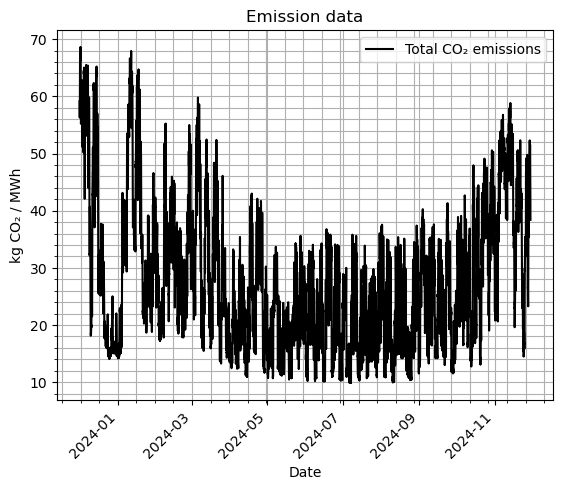

In [4]:
co2_emissions_by_source = []
total_power = np.zeros(len(power_data[0]["data"]))

for i in range(len(power_data)):
    co2_data = np.array([value if value is not None else 0 for value in power_data[i]["data"]]) * co2_per_mwh[i][1]
    total_power = np.add(total_power, np.array([value if value is not None else 0 for value in power_data[i]["data"]]))
    co2_emissions_by_source.append((co2_per_mwh[i][0],co2_data))
for i in range(len(power_data)):
    co2_emissions_by_source[i] = (co2_emissions_by_source[i][0], 
                                  np.divide(co2_emissions_by_source[i][1], total_power[i], where=total_power != 0))

co2_emissions_total = np.sum([source[1] for source in co2_emissions_by_source], axis=0)

fig, ax = plt.subplots()
ax.plot(dates, co2_emissions_total, label="Total CO₂ emissions", color="black")
plt.title("Emission data")
plt.xlabel("Date")
plt.ylabel("kg CO₂ / MWh")
plt.grid(visible=True, which='both', axis='both')
plt.xticks(rotation=45, ha='right')
plt.grid(visible=True, which='both', axis='both')
plt.minorticks_on()
plt.legend()
plt.show()

# Define the $CO_2$ function

In [5]:
def server_emission(utilisation, co2_emission_per_mwh, active_consumption, co2_base):
    return np.where(utilisation <= 0, np.inf, co2_base / np.where(utilisation > 0, utilisation, np.nan) + co2_emission_per_mwh * active_consumption)

In [6]:
probe_co2 = np.linspace(min(co2_emissions_total), max(co2_emissions_total), 100)
utilisation = np.ndarray(len(probe_co2))
co2_sum = np.ndarray(len(probe_co2))
time_delta = timestamps[len(timestamps) - 1] - timestamps[0]

for n, probe in enumerate(probe_co2):
    t_utilisation = 0
    co2_times_dt = 0
    for i in range(1, len(co2_emissions_total) - 1):
        if co2_emissions_total[i] < probe:
            dt = ((timestamps[i+1] - timestamps[i]) + (timestamps[i] - timestamps[i-1])) / 2
            t_utilisation += dt
            co2_times_dt += co2_emissions_total[i] * dt
    utilisation[n] = t_utilisation / time_delta if time_delta != 0 else 0
    co2_sum[n] = co2_times_dt / t_utilisation if t_utilisation != 0 else 0

# show example utilisation
For each of the $n=4288$ cores, the following values are given:
- $W_{\text{active}}=1.1\cdot 10^{-5}MW$
- $E_\text{production}+W_\text{base}\cdot \langle e_\text{total mean}\rangle\approx (4617+4288+2+4525+1-199) kg / (4\cdot 365\cdot 24h) / 256\approx 0.00147\ kg / h$ 

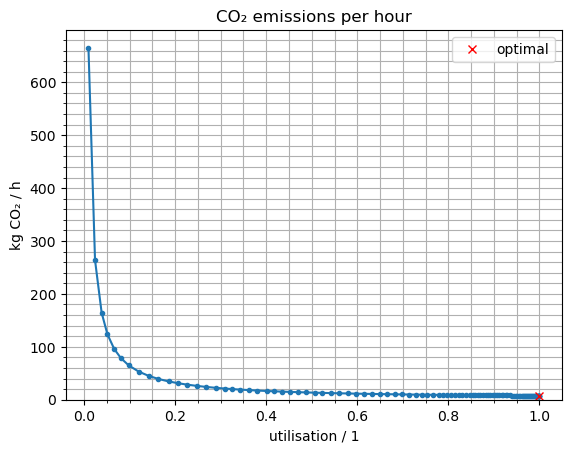

Optimal utilisation: 99.99%
Savings relative to 100% utilisation: 0.00%


In [7]:
oc = 4288 * server_emission(utilisation, co2_sum, 1.1e-5, 0.00147)
plt.plot(utilisation, oc, ".-")
plt.plot(utilisation[np.argmin(oc)], np.min(oc), "rx", label="optimal")
plt.title("CO₂ emissions per hour")
plt.xlabel("utilisation / 1")
plt.ylabel("kg CO₂ / h")
plt.ylim(0)
plt.grid(visible=True, which='both', axis='both')
plt.minorticks_on()
plt.legend()
plt.show()

print(f"Optimal utilisation: {utilisation[np.argmin(oc)]:.2%}\nSavings relative to 100% utilisation: {(1 - np.min(oc) / oc[-1]):.2%}")

# Calculate the optimal utilisation for different base emissions

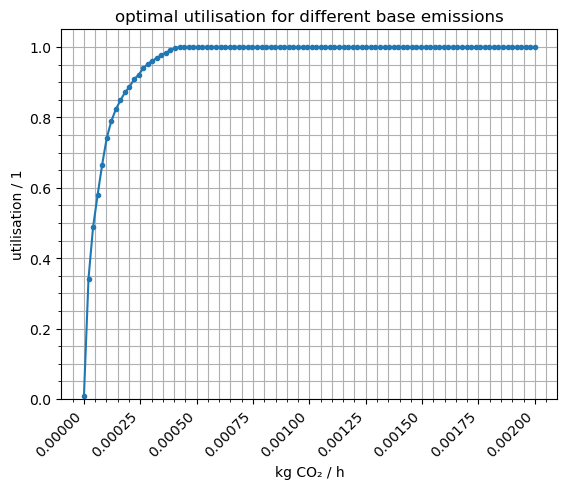

In [8]:
emissions = np.linspace(0,0.002,100)	
min_emissions = [utilisation[np.argmin(server_emission(utilisation, co2_sum, 1.1e-5, emission))] for emission in emissions]
plt.plot(emissions, min_emissions, ".-")
plt.title("optimal utilisation for different base emissions")
plt.ylabel("utilisation / 1")
plt.xlabel("kg CO₂ / h")
plt.ylim(0)
plt.grid(visible=True, which='both', axis='both')
plt.minorticks_on()
plt.xticks(rotation=45, ha='right')
plt.show()